![image.png](attachment:image.png)

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base.

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado).

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


# 0. Preparando a base

In [17]:
# verificando se há dados faltantes
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [18]:
# Verificando os ultimos dados do dataframe
df.tail(5)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2016-03-01,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
2016-03-01,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,4084.37
2016-03-01,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66
2016-03-01,3024,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49
2016-03-01,6074,F,N,S,0,Pensionista,Superior completo,Separado,Casa,62,NaN,1.0,2243.21


In [19]:
# Removendo a ultima linha e substituindo os valores nulls pela média
df.drop(df.index[-1], inplace=True)
df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean(), inplace=True)

# Verificando novamente os dados nulos
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [20]:
# Separando bases de treino e teste baseado na data
df_train = df[:'2015-01-31']
df_test = df['2015-02-01':]

# Criando as variáveis log_renda
df_train['log_renda']=np.log(df_train['renda'])
df_test['log_renda']=np.log(df_test['renda'])

<ipython-input-20-897bc045231c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_renda']=np.log(df_train['renda'])
<ipython-input-20-897bc045231c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_renda']=np.log(df_test['renda'])


In [21]:
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + qtd_filhos
                    + idade
                    + tempo_emprego
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net', refit = True, L1_wt = 1, alpha = 0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                 1.481e+04
Date:                Thu, 16 May 2024   Prob (F-statistic):               0.00
Time:                        18:11:34   Log-Likelihood:                -55560.
No. Observations:               50000   AIC:                         1.111e+05
Df Residuals:                   49996   BIC:                         1.112e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.3993      0.014    541.079      0.000       7.373       7.426
C(posse_de_imovel)[T.S]     0.1819      0.007     25.792      0.000       0.168       0.196
qtd_filhos                       0          0        nan        nan           0           0
idade                      -0.0053      0.000    -17.428      0.000      -0.006      -0.005
tempo_emprego               0.1316      0.001    238.163      0.000       0.131       0.133
==============================================================================
Omnibus:                       10.676   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.160
Skew:                          -0.015   Prob(JB):                      0.00377
Kurtosis:                       3.067   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Testando com menos variáveis, podemos chegar no modelo abaixo, tendo pouca diferença no r2
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + tempo_emprego
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net', refit = True, L1_wt = 1, alpha = 0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                 1.952e+04
Date:                Thu, 16 May 2024   Prob (F-statistic):               0.00
Time:                        18:11:50   Log-Likelihood:                -55711.
No. Observations:               50000   AIC:                         1.114e+05
Df Residuals:                   49997   BIC:                         1.115e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.1954      0.007   1013.152      0.000       7.182       7.209
C(posse_de_imovel)[T.S]     0.1658      0.007     23.641      0.000       0.152       0.179
tempo_emprego               0.1292      0.001    240.898      0.000       0.128       0.130
==============================================================================
Omnibus:                       12.571   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.239
Skew:                          -0.015   Prob(JB):                      0.00133
Kurtosis:                       3.074   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

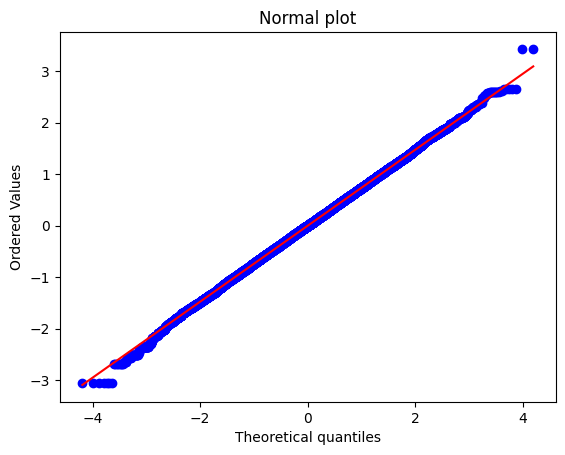

In [24]:
# gráfico para verificar se os resíduos seguem uma distribuição normal
residuos = res.resid
ss.probplot(residuos, dist="norm", plot=plt)
plt.title("Normal plot")
plt.show()

> Como visto no gráfico, os resíduos seguem uma distruibuição normal, atendendo uma das suposições da regressão linear.










## VERIFICANDO A INDEPENDÊNCIA DOS RESÍDUOS:

<ipython-input-25-779cc00e7962>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['residuos'] = res.resid


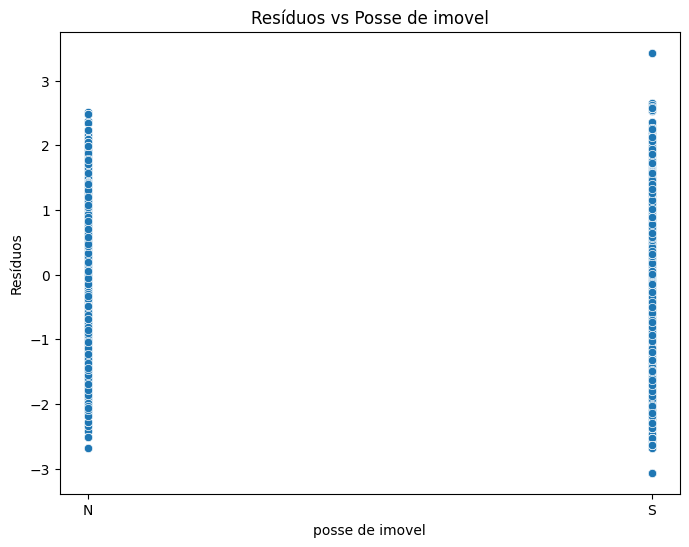

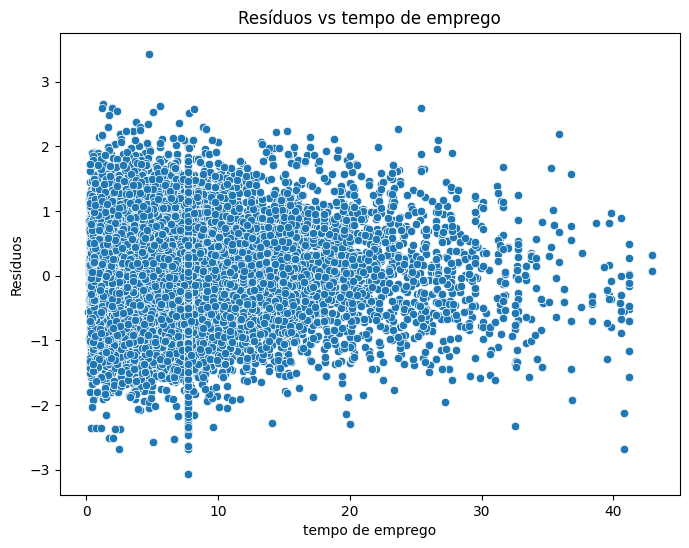

In [25]:
# Calculando os resíduos
df_train['residuos'] = res.resid

# Gráfico de dispersão para 'posse_de_imovel'
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_train['posse_de_imovel'], y=df_train['residuos'])
plt.title('Resíduos vs Posse de imovel')
plt.xlabel('posse de imovel')
plt.ylabel('Resíduos')
plt.show()

# Gráfico de dispersão para 'tempo_emprego'
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_train['tempo_emprego'], y=df_train['residuos'])
plt.title('Resíduos vs tempo de emprego')
plt.xlabel('tempo de emprego')
plt.ylabel('Resíduos')
plt.show()

> No primeiro gráfico podemos ver uma boa distribuição, mostrando uma distribuição aleatória, o que reafirma a independência dos resíduos.

> Já no segundo gráfico podemos verificar que o gráfico também possui uma distribuição visualmente aleatória.

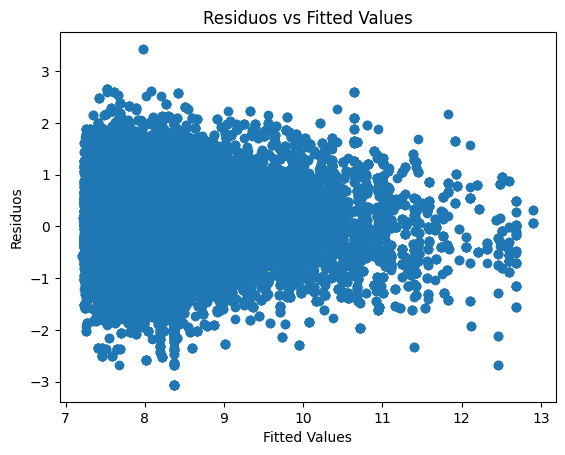

In [26]:
# HOMOCEDASTICIDADE:
plt.scatter(res.fittedvalues, residuos)
plt.title('Residuos vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuos')
plt.show()

> O gráfico de dispersão plotado nos mostra uma boa aleatoriedade dos valores, o que nos atende

In [27]:
df_train.columns

Index(['index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'log_renda',
       'residuos'],
      dtype='object')

In [28]:
# Transformando posse de imovel em dummie
df_train = pd.get_dummies(df_train, columns=['posse_de_imovel'], drop_first=True)

# Obtendo as variáveis independentes do modelo
X = df_train[['posse_de_imovel_S', 'tempo_emprego']]

# Adicionando uma constante para o intercepto
X = sm.add_constant(X)

# Calculando o valor de inflação da variancia (VIF) para cada variável
vif = pd.DataFrame()
vif["variaveis"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values.astype(float), i) for i in range(X.shape[1])]

print(vif)

           variaveis       VIF
0              const  4.638484
1  posse_de_imovel_S  1.000003
2      tempo_emprego  1.000003


> O resultado nos mostra que as duas variáveis independentes não estão altamente correlacionadas entre si, sendo algo bom para o nosso modelo

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

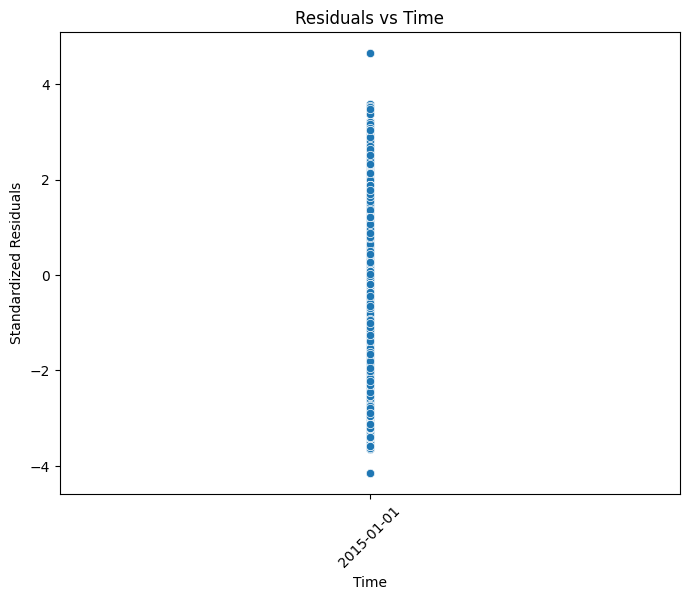

In [29]:
# Ajustando o modelo usando a função 'fit'
y, X = X1
model = sm.OLS(y, X)
results = model.fit()

# Calculando os resíduos padronizados
df_train['residuos_padronizados'] = results.get_influence().resid_studentized_internal

# Criando um gráfico dos resíduos padronizados
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_train.index, y=df_train['residuos_padronizados'])
plt.title('Residuals vs Time')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Standardized Residuals')
plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [30]:
# Calculando a matriz de correlação de Spearman
correlation_matrix = df_train[['posse_de_imovel_S', 'tempo_emprego']].corr(method='spearman')

# Imprimindo a matriz de correlação
print(correlation_matrix)

                   posse_de_imovel_S  tempo_emprego
posse_de_imovel_S           1.000000       0.007385
tempo_emprego               0.007385       1.000000


In [31]:
# Como já haviamos calculado o vif anteriormente, vamos apenas mostra-los
print(vif)

           variaveis       VIF
0              const  4.638484
1  posse_de_imovel_S  1.000003
2      tempo_emprego  1.000003


> tanto na matriz de correlação de Spearman quanto na VIF podemos observar uma não correlação entre as variáveis, o que é algo bom para o modelo